# Example Predictor: Linear Rollout Predictor

This example contains basic functionality for training and evaluating a linear predictor that rolls out predictions day-by-day.

First, a training data set is created from historical case and npi data.

Second, a linear model is trained to predict future cases from prior case data along with prior and future npi data.
The model is an off-the-shelf sklearn Lasso model, that uses a positive weight constraint to enforce the assumption that increased npis has a negative correlation with future cases.

Third, a sample evaluation set is created, and the predictor is applied to this evaluation set to produce prediction results in the correct format.

## Training

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [3]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))

### Copy the data locally

In [4]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [5]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7fdaf68516d0>)

In [6]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [7]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [8]:
# # For testing, restrict training data to that before a hypothetical predictor submission date
# HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
# df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [9]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [10]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [11]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [12]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [13]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [14]:
temp = pd.read_csv('temperature_data.csv')
temp['date_st'] = temp['Date'].apply(lambda e: e[5:])
temp['id'] = temp['GeoID'] + '_' + temp['date_st']
id_temp = dict(zip( temp['id'], temp['temp'] ))
id_holiday = dict(zip( temp['id'], temp['Holiday'] ))
tf = temp[['date_st','temp']]
tf = tf.groupby(['date_st']).mean().reset_index()
date_temp_avg = dict(zip( tf['date_st'], tf['temp'] ))
tf = temp[['date_st','Holiday']]
tf = tf.groupby(['date_st'])['Holiday'].agg(pd.Series.mode).reset_index()
date_holiday_avg = dict(zip( tf['date_st'], tf['Holiday'] ))

In [15]:
# Set number of past days to use to make predictions
nb_lookback_days = 30
date_ls = []
geoid_ls = []
country_ls = []
newcase_ls = []
# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col
X_samples = []
y_samples = []
geo_ids = df.GeoID.unique()
train_geo_ids = [e for e in geo_ids]
geoid_arr = np.zeros(len(train_geo_ids)+1)
for g in geo_ids:
    gdf = df[df.GeoID == g]
    all_case_data = np.array(gdf[cases_col])
    all_npi_data = np.array(gdf[npi_cols])

    # Create one sample for each day where we have enough data
    # Each sample consists of cases and npis for previous nb_lookback_days
    nb_total_days = len(gdf)
    for d in range(nb_lookback_days, nb_total_days - 1):
        X_cases = all_case_data[d-nb_lookback_days:d]

        # Take negative of npis to support positive
        # weight constraint in Lasso.
        X_npis = -all_npi_data[d - nb_lookback_days:d]
        
        date_ls += [ list(gdf['Date'])[d] ]
        geoid_ls += [ list(gdf['GeoID'])[d] ]
        country_ls += [ list(gdf['CountryName'])[d]  ] 
        newcase_ls += [ list(gdf['NewCases'])[d]  ] 
        
        date_st = str(date_ls[-1])[5:10] 
        id_ = geoid_ls[-1] + '_' + date_st

        temperature = date_temp_avg[date_st]
        holiday = date_holiday_avg[date_st]
        if id_ in id_temp:
            temperature = id_temp[id_]
            holiday = id_holiday[id_]            
        
        # Flatten all input data so it fits Lasso input format.
        geoid_arr = np.zeros(len(train_geo_ids)+1)
        geoid_arr[ train_geo_ids.index(g) ] = 1
        X_sample = np.concatenate([[temperature,holiday], X_cases.flatten(), #geoid_arr,
                                   X_npis.flatten()])
        y_sample = all_case_data[d]
        X_samples.append(X_sample)
        y_samples.append(y_sample)


X_samples = np.array(X_samples)
y_samples = np.array(y_samples).flatten()
y_samples = np.maximum(y_samples, 0) # Don't predict negative cases
with open('train_geo_ids.txt', 'w') as f:
    f.write('\n'.join(train_geo_ids))
    
print(X_samples.shape)

(91000, 392)


In [16]:
len(set(geoid_ls))

280

In [17]:
# Split data into train and test sets
X_train_all,  y_train_all = X_samples, y_samples
print(X_train_all.shape, y_train_all.shape)

(91000, 392) (91000,)


In [18]:
# geoid_ls = np.array(geoid_ls)

In [19]:
!pip install lightgbm

In [20]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42) 

In [21]:
# !pip install optuna

In [22]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import lightgbm as lgb


params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'subsample': 0.5,
    'subsample_freq': 1,
    'learning_rate': 0.03,
    'num_leaves': 2 ** 5 - 1,#11
    'min_data_in_leaf': 2 ** 6 - 1,#12
    'feature_fraction': 0.5,
    'max_bin': 100,
    'n_estimators': 1000,#140,#140,#0,
    'boost_from_average': False,
    'verbose': -1,
}




for ii in range(len(train_geo_ids)):
    g = train_geo_ids[ii]
    MODEL_FILE = 'models/lgb_' + g + '.pkl'
    if True:#not(os.path.exists(MODEL_FILE)):
        tr_idx = [i for i in range(len(geoid_ls)) if geoid_ls[i]==g ]
        tr_idx = np.array(tr_idx)
        X_train, y_train = X_train_all[tr_idx,:], y_train_all[tr_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        lgb_model_tune = lgb.train(params, dtrain, valid_sets=[dtrain], early_stopping_rounds=100,verbose_eval=100 )

        with open(MODEL_FILE, 'wb') as model_file:
            pickle.dump(lgb_model_tune, model_file)    

        if (ii%10==0):
            print('have done ', ii//10, ' models')

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 18.8993
[200]	training's rmse: 16.4464
[300]	training's rmse: 15.6534
[400]	training's rmse: 15.2072
[500]	training's rmse: 14.8694
[600]	training's rmse: 14.5966
[700]	training's rmse: 14.3779
[800]	training's rmse: 14.1698
[900]	training's rmse: 14.0077
[1000]	training's rmse: 13.8421
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 13.8421
have done  0  models
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 110.461
[200]	training's rmse: 94.4886
[300]	training's rmse: 85.8928
[400]	training's rmse: 79.2295
[500]	training's rmse: 74.0588
[600]	training's rmse: 70.1331
[700]	training's rmse: 66.6046
[800]	training's rmse: 63.5695
[900]	training's rmse: 61.3611
[1000]	training's rmse: 59.1036
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 59.1036
Training until validation scores don't improve for 100 rounds
[100]	train

[500]	training's rmse: 202.854
[600]	training's rmse: 198.065
[700]	training's rmse: 194.731
[800]	training's rmse: 191.802
[900]	training's rmse: 189.155
[1000]	training's rmse: 186.666
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 186.666
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 243.632
[200]	training's rmse: 221.521
[300]	training's rmse: 214.458
[400]	training's rmse: 209.935
[500]	training's rmse: 206.331
[600]	training's rmse: 203.231
[700]	training's rmse: 201.124
[800]	training's rmse: 199.139
[900]	training's rmse: 197.378
[1000]	training's rmse: 195.818
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 195.818
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 81.6525
[200]	training's rmse: 80.5259
[300]	training's rmse: 79.6742
[400]	training's rmse: 79.1132
[500]	training's rmse: 78.5971
[600]	training's rmse: 78.2301
[700]	training's rmse: 77.9061
[

[800]	training's rmse: 566.135
[900]	training's rmse: 559.642
[1000]	training's rmse: 553.912
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 553.912
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 395.082
[200]	training's rmse: 377.09
[300]	training's rmse: 363.745
[400]	training's rmse: 353.9
[500]	training's rmse: 345.688
[600]	training's rmse: 338.99
[700]	training's rmse: 333.153
[800]	training's rmse: 328.439
[900]	training's rmse: 324.055
[1000]	training's rmse: 320.063
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 320.063
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 466.911
[200]	training's rmse: 450.816
[300]	training's rmse: 441.273
[400]	training's rmse: 432.897
[500]	training's rmse: 426.751
[600]	training's rmse: 420.843
[700]	training's rmse: 415.541
[800]	training's rmse: 410.951
[900]	training's rmse: 406.313
[1000]	training's rmse: 401.729
Did 

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 28.5552
[200]	training's rmse: 26.2857
[300]	training's rmse: 25.2341
[400]	training's rmse: 24.5654
[500]	training's rmse: 24.0311
[600]	training's rmse: 23.6467
[700]	training's rmse: 23.3452
[800]	training's rmse: 23.0824
[900]	training's rmse: 22.8803
[1000]	training's rmse: 22.6764
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 22.6764
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 342.076
[200]	training's rmse: 301.614
[300]	training's rmse: 288.477
[400]	training's rmse: 279.515
[500]	training's rmse: 273.378
[600]	training's rmse: 267.85
[700]	training's rmse: 262.728
[800]	training's rmse: 258.904
[900]	training's rmse: 255.003
[1000]	training's rmse: 251.815
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 251.815
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 131.263
[2

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 54.2176
[200]	training's rmse: 49.6581
[300]	training's rmse: 46.9456
[400]	training's rmse: 45.1687
[500]	training's rmse: 43.854
[600]	training's rmse: 42.6516
[700]	training's rmse: 41.5787
[800]	training's rmse: 40.7591
[900]	training's rmse: 40.0417
[1000]	training's rmse: 39.3559
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 39.3559
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 188.143
[200]	training's rmse: 183.864
[300]	training's rmse: 180.616
[400]	training's rmse: 178.608
[500]	training's rmse: 176.99
[600]	training's rmse: 175.705
[700]	training's rmse: 174.692
[800]	training's rmse: 173.845
[900]	training's rmse: 172.959
[1000]	training's rmse: 172.124
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 172.124
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 39.2833
[20

[200]	training's rmse: 180.683
[300]	training's rmse: 168.082
[400]	training's rmse: 158.269
[500]	training's rmse: 150.36
[600]	training's rmse: 143.506
[700]	training's rmse: 137.43
[800]	training's rmse: 132.486
[900]	training's rmse: 128.078
[1000]	training's rmse: 124.231
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 124.231
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.38903
[200]	training's rmse: 6.36263
[300]	training's rmse: 6.33141
[400]	training's rmse: 6.30053
[500]	training's rmse: 6.28203
[600]	training's rmse: 6.26513
[700]	training's rmse: 6.25593
[800]	training's rmse: 6.24484
[900]	training's rmse: 6.23377
[1000]	training's rmse: 6.2187
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 6.2187
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 5783.44
[200]	training's rmse: 5168.72
[300]	training's rmse: 4786.65
[400]	training's rmse: 4559.88
[500]

[700]	training's rmse: 23.2974
[800]	training's rmse: 22.8202
[900]	training's rmse: 22.4313
[1000]	training's rmse: 22.1145
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 22.1145
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 410.332
[200]	training's rmse: 337.135
[300]	training's rmse: 300.585
[400]	training's rmse: 279.387
[500]	training's rmse: 265.206
[600]	training's rmse: 255.426
[700]	training's rmse: 249.019
[800]	training's rmse: 243.918
[900]	training's rmse: 239.881
[1000]	training's rmse: 236.439
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 236.439
have done  11  models
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.306647
[200]	training's rmse: 0.301878
[300]	training's rmse: 0.298565
[400]	training's rmse: 0.295695
[500]	training's rmse: 0.293811
[600]	training's rmse: 0.292113
[700]	training's rmse: 0.290223
[800]	training's rmse: 0.2888
[900

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 31.3069
[200]	training's rmse: 28.8417
[300]	training's rmse: 27.6307
[400]	training's rmse: 26.7609
[500]	training's rmse: 26.0471
[600]	training's rmse: 25.491
[700]	training's rmse: 25.0644
[800]	training's rmse: 24.7144
[900]	training's rmse: 24.4235
[1000]	training's rmse: 24.0818
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 24.0818
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 868.485
[200]	training's rmse: 763.018
[300]	training's rmse: 724.402
[400]	training's rmse: 699.915
[500]	training's rmse: 681.223
[600]	training's rmse: 667.305
[700]	training's rmse: 657.493
[800]	training's rmse: 649.462
[900]	training's rmse: 641.751
[1000]	training's rmse: 633.626
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 633.626
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 396.16
[20

[500]	training's rmse: 0.557378
[600]	training's rmse: 0.556514
[700]	training's rmse: 0.555505
[800]	training's rmse: 0.554642
[900]	training's rmse: 0.55389
[1000]	training's rmse: 0.552922
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.552922
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 694.48
[200]	training's rmse: 591.325
[300]	training's rmse: 548.22
[400]	training's rmse: 519.192
[500]	training's rmse: 495.458
[600]	training's rmse: 474.894
[700]	training's rmse: 459.885
[800]	training's rmse: 448.492
[900]	training's rmse: 438.298
[1000]	training's rmse: 430.463
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 430.463
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.12462
[200]	training's rmse: 3.03163
[300]	training's rmse: 2.98935
[400]	training's rmse: 2.95733
[500]	training's rmse: 2.93073
[600]	training's rmse: 2.91333
[700]	training's rmse: 2.895

[700]	training's rmse: 62.7511
[800]	training's rmse: 62.568
[900]	training's rmse: 62.3519
[1000]	training's rmse: 62.1696
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 62.1696
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1510.84
[200]	training's rmse: 1338.74
[300]	training's rmse: 1261.46
[400]	training's rmse: 1214.5
[500]	training's rmse: 1182.01
[600]	training's rmse: 1154.43
[700]	training's rmse: 1130.79
[800]	training's rmse: 1108.94
[900]	training's rmse: 1089.49
[1000]	training's rmse: 1070.1
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1070.1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 122.305
[200]	training's rmse: 112.621
[300]	training's rmse: 107.197
[400]	training's rmse: 104.525
[500]	training's rmse: 102.279
[600]	training's rmse: 100.653
[700]	training's rmse: 99.3716
[800]	training's rmse: 98.0911
[900]	training's rmse: 97.295
[1000]

[800]	training's rmse: 878.527
[900]	training's rmse: 871.593
[1000]	training's rmse: 865.71
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 865.71
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3559.6
[200]	training's rmse: 3018.45
[300]	training's rmse: 2849.77
[400]	training's rmse: 2725
[500]	training's rmse: 2642.61
[600]	training's rmse: 2557.65
[700]	training's rmse: 2490.4
[800]	training's rmse: 2434.39
[900]	training's rmse: 2378.97
[1000]	training's rmse: 2340.45
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 2340.45
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 24.788
[200]	training's rmse: 23.8938
[300]	training's rmse: 23.2376
[400]	training's rmse: 22.7526
[500]	training's rmse: 22.3523
[600]	training's rmse: 22.0137
[700]	training's rmse: 21.7558
[800]	training's rmse: 21.52
[900]	training's rmse: 21.2801
[1000]	training's rmse: 21.0961
Did not me

have done  20  models
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.15212
[200]	training's rmse: 3.10776
[300]	training's rmse: 3.06743
[400]	training's rmse: 3.03806
[500]	training's rmse: 3.00512
[600]	training's rmse: 2.97052
[700]	training's rmse: 2.94143
[800]	training's rmse: 2.91453
[900]	training's rmse: 2.89208
[1000]	training's rmse: 2.8727
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 2.87239
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 16.1467
[200]	training's rmse: 13.7958
[300]	training's rmse: 12.6877
[400]	training's rmse: 12.0968
[500]	training's rmse: 11.7453
[600]	training's rmse: 11.4889
[700]	training's rmse: 11.2955
[800]	training's rmse: 11.1351
[900]	training's rmse: 11.0062
[1000]	training's rmse: 10.8946
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 10.8946
Training until validation scores don't improve for 100 rounds
[100]	traini

[800]	training's rmse: 75.7313
[900]	training's rmse: 74.5568
[1000]	training's rmse: 73.432
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 73.4295
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 592.879
[200]	training's rmse: 558.678
[300]	training's rmse: 541.287
[400]	training's rmse: 524.468
[500]	training's rmse: 511.534
[600]	training's rmse: 501.238
[700]	training's rmse: 492.118
[800]	training's rmse: 484.647
[900]	training's rmse: 478.53
[1000]	training's rmse: 473.166
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 473.166
have done  22  models
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 353.045
[200]	training's rmse: 310.808
[300]	training's rmse: 291.657
[400]	training's rmse: 281.377
[500]	training's rmse: 272.856
[600]	training's rmse: 265.519
[700]	training's rmse: 259.862
[800]	training's rmse: 255.643
[900]	training's rmse: 252.387
[1000]	traini

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 808.815
[200]	training's rmse: 759.607
[300]	training's rmse: 744.557
[400]	training's rmse: 735.061
[500]	training's rmse: 726.742
[600]	training's rmse: 719.257
[700]	training's rmse: 713.434
[800]	training's rmse: 708.453
[900]	training's rmse: 703.703
[1000]	training's rmse: 698.44
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 698.44
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 383.485
[200]	training's rmse: 308.01
[300]	training's rmse: 278.431
[400]	training's rmse: 264.622
[500]	training's rmse: 256.882
[600]	training's rmse: 251.873
[700]	training's rmse: 248.043
[800]	training's rmse: 245.207
[900]	training's rmse: 242.741
[1000]	training's rmse: 240.477
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 240.477
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 63.4012
[200

[600]	training's rmse: 211.458
[700]	training's rmse: 208.042
[800]	training's rmse: 205.385
[900]	training's rmse: 202.835
[1000]	training's rmse: 200.927
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 200.927
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1538.53
[200]	training's rmse: 1234.26
[300]	training's rmse: 1104.62
[400]	training's rmse: 1050.09
[500]	training's rmse: 1020.12
[600]	training's rmse: 1001.42
[700]	training's rmse: 989.922
[800]	training's rmse: 980.214
[900]	training's rmse: 971.302
[1000]	training's rmse: 963.342
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 963.342
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 357.679
[200]	training's rmse: 325.93
[300]	training's rmse: 308.805
[400]	training's rmse: 296.546
[500]	training's rmse: 286.871
[600]	training's rmse: 279.102
[700]	training's rmse: 273.521
[800]	training's rmse: 268.745
[9

[700]	training's rmse: 4.8336
[800]	training's rmse: 4.73853
[900]	training's rmse: 4.65875
[1000]	training's rmse: 4.59164
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 4.59164
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0550336
[200]	training's rmse: 0.0547936
[300]	training's rmse: 0.0545932
[400]	training's rmse: 0.054339
[500]	training's rmse: 0.0540586
[600]	training's rmse: 0.0538419
[700]	training's rmse: 0.0536645
[800]	training's rmse: 0.0533939
[900]	training's rmse: 0.0531805
[1000]	training's rmse: 0.0530319
Did not meet early stopping. Best iteration is:
[996]	training's rmse: 0.0530306
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 9.70926
[200]	training's rmse: 9.43367
[300]	training's rmse: 9.29668
[400]	training's rmse: 9.1773
[500]	training's rmse: 9.08779
[600]	training's rmse: 9.01355
[700]	training's rmse: 8.94336
[800]	training's rmse: 8.88302
[900]	training

## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data.

In [23]:
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df

In [24]:
# %%time
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="data/2020-09-30_historical_ip.csv", verbose=True)


Predicting for Aruba__nan
2020-08-01: 7.181268985605374
2020-08-02: 13.021495384044648
2020-08-03: 21.53438357926397
2020-08-04: 23.41009330502933
2020-08-05: 24.689353466227143
2020-08-06: 22.131184281432027
2020-08-07: 21.32880792716946
2020-08-08: 21.432149483361187
2020-08-09: 29.01917291125567
2020-08-10: 31.85762417155398
2020-08-11: 28.50245387308171
2020-08-12: 28.252291713274804
2020-08-13: 28.107564925562794
2020-08-14: 26.330616927562968
2020-08-15: 25.46231326500272
2020-08-16: 25.65687829655087
2020-08-17: 26.239284375105644
2020-08-18: 25.397974128394697
2020-08-19: 24.774320109766837
2020-08-20: 24.429615281848672
2020-08-21: 22.355742853644884
2020-08-22: 21.266165150864442
2020-08-23: 24.03639909871446
2020-08-24: 25.770369300860715
2020-08-25: 26.365506836708974
2020-08-26: 27.06382800588497
2020-08-27: 26.11972685836012
2020-08-28: 25.888176346532216
2020-08-29: 24.956423463142595
2020-08-30: 24.46747187703036
2020-08-31: 25.402400127066066

Predicting for Afghanist


Predicting for Burkina Faso__nan
2020-08-01: 29.162453784290072
2020-08-02: 47.97888417339039
2020-08-03: 39.62633009240884
2020-08-04: 56.532887833310824
2020-08-05: 51.625268378554395
2020-08-06: 57.978556039914
2020-08-07: 56.30763719827097
2020-08-08: 62.20513143931702
2020-08-09: 53.94573174913827
2020-08-10: 62.65314712474879
2020-08-11: 56.50010788129137
2020-08-12: 44.840253476066394
2020-08-13: 57.96010535419858
2020-08-14: 53.54953616847431
2020-08-15: 63.18805084036485
2020-08-16: 66.03401060759249
2020-08-17: 56.633639220171
2020-08-18: 60.968561511835304
2020-08-19: 61.18935591646886
2020-08-20: 58.697610059235295
2020-08-21: 58.236402130898824
2020-08-22: 65.1610729227229
2020-08-23: 57.459421209328006
2020-08-24: 57.802794688604976
2020-08-25: 65.84507616009654
2020-08-26: 59.77354524277173
2020-08-27: 56.69874266359857
2020-08-28: 54.42083105460037
2020-08-29: 53.879525712136996
2020-08-30: 59.200064051254394
2020-08-31: 61.751805060300235

Predicting for Bangladesh__n

2020-08-20: 902.6392130392312
2020-08-21: 853.1127504332289
2020-08-22: 833.1363362185652
2020-08-23: 792.5456055811712
2020-08-24: 746.4917353005958
2020-08-25: 904.2720327162473
2020-08-26: 843.2565711781084
2020-08-27: 701.3612445828209
2020-08-28: 745.2770729009961
2020-08-29: 777.8568105689104
2020-08-30: 909.371728240743
2020-08-31: 1002.2626352373616

Predicting for Brazil__Acre
2020-08-01: 107.5290015995789
2020-08-02: 169.17805808092294
2020-08-03: 114.6291048732825
2020-08-04: 130.47955171977534
2020-08-05: 14.950463224059725
2020-08-06: 56.488700971105445
2020-08-07: 133.08107141586245
2020-08-08: 119.12563013493998
2020-08-09: 151.52924728096713
2020-08-10: 164.56855207677023
2020-08-11: 121.05405690996135
2020-08-12: 85.52541250135006
2020-08-13: 105.2259801846535
2020-08-14: 178.78884152623414
2020-08-15: 182.90307863274347
2020-08-16: 184.9110242519917
2020-08-17: 166.24441429030458
2020-08-18: 112.23531942851729
2020-08-19: 105.21943029977209
2020-08-20: 57.381497910855


Predicting for Brazil__Maranhao
2020-08-01: 603.7348938454434
2020-08-02: 1041.3472813943629
2020-08-03: 720.1870821220106
2020-08-04: 351.5375702943626
2020-08-05: 0
2020-08-06: 0
2020-08-07: 243.03602896322903
2020-08-08: 772.4444000148592
2020-08-09: 1233.975517566198
2020-08-10: 727.2058545651644
2020-08-11: 182.72094597129407
2020-08-12: 0
2020-08-13: 80.30997945585763
2020-08-14: 463.8908951541752
2020-08-15: 1157.6921736098434
2020-08-16: 1135.5072458997588
2020-08-17: 542.5547571332567
2020-08-18: 171.1209124007355
2020-08-19: 0
2020-08-20: 198.6716873882559
2020-08-21: 420.38190134204655
2020-08-22: 1032.87981275737
2020-08-23: 973.9312173032926
2020-08-24: 484.0699272034727
2020-08-25: 227.64610721466434
2020-08-26: 0
2020-08-27: 128.75065496557968
2020-08-28: 462.0326020828266
2020-08-29: 969.0886949936084
2020-08-30: 969.9387153610554
2020-08-31: 336.6673527287309

Predicting for Brazil__Minas Gerais
2020-08-01: 1534.015821124561
2020-08-02: 2730.394468016243
2020-08-03: 2

2020-08-12: 1031.9539779239174
2020-08-13: 1528.5650681155435
2020-08-14: 1614.4546302878512
2020-08-15: 2211.2947891620884
2020-08-16: 2440.2379650889347
2020-08-17: 2246.1332045719223
2020-08-18: 2262.26902504243
2020-08-19: 2170.8643111747733
2020-08-20: 1505.6323448788326
2020-08-21: 1270.8971651514782
2020-08-22: 1404.2277374661985
2020-08-23: 2154.0226893873873
2020-08-24: 2197.6151605295927
2020-08-25: 1906.2513848684105
2020-08-26: 2019.4540437414685
2020-08-27: 2333.021163945717
2020-08-28: 1830.9811244185382
2020-08-29: 1697.9942889988042
2020-08-30: 1809.021268369726
2020-08-31: 1918.4714208417586

Predicting for Brazil__Rio Grande do Norte
2020-08-01: 0
2020-08-02: 3.394521602408579
2020-08-03: 109.32401129897349
2020-08-04: 224.09476751600442
2020-08-05: 325.9662322562431
2020-08-06: 223.49568932766428
2020-08-07: 112.63726308443438
2020-08-08: 237.05184785253655
2020-08-09: 440.07339539325267
2020-08-10: 537.1108504955156
2020-08-11: 259.1106361527627
2020-08-12: 267.0236

2020-08-10: 1.4968649455255902
2020-08-11: 1.4462872541994216
2020-08-12: 1.1518049664734034
2020-08-13: 1.6190511867886268
2020-08-14: 1.683059350526007
2020-08-15: 1.9731933710642329
2020-08-16: 1.8250150208220721
2020-08-17: 1.7747767399003116
2020-08-18: 1.7044252041896901
2020-08-19: 1.6800016680156173
2020-08-20: 1.737696192330764
2020-08-21: 1.6531201244723674
2020-08-22: 1.7245277619016963
2020-08-23: 1.695030879244258
2020-08-24: 1.7299163507271902
2020-08-25: 1.6583714972313566
2020-08-26: 1.6773624365648565
2020-08-27: 1.6401128446267446
2020-08-28: 1.6591683191987905
2020-08-29: 1.641128760735316
2020-08-30: 1.641128760735316
2020-08-31: 1.6310352127796282

Predicting for Brunei__nan
2020-08-01: 2.405488478703682
2020-08-02: 2.368034740382298
2020-08-03: 2.456013265746411
2020-08-04: 2.369887138707656
2020-08-05: 2.369887138707656
2020-08-06: 2.355881159517253
2020-08-07: 2.355881159517253
2020-08-08: 2.3236997392316456
2020-08-09: 2.3236997392316456
2020-08-10: 2.355881159

2020-08-01: 20.186145744600598
2020-08-02: 20.186145744600598
2020-08-03: 21.493006798673512
2020-08-04: 21.493006798673512
2020-08-05: 21.493006798673512
2020-08-06: 21.493006798673512
2020-08-07: 21.493006798673512
2020-08-08: 20.186145744600598
2020-08-09: 20.186145744600598
2020-08-10: 21.493006798673512
2020-08-11: 21.493006798673512
2020-08-12: 21.493006798673512
2020-08-13: 21.493006798673512
2020-08-14: 21.493006798673512
2020-08-15: 20.186145744600598
2020-08-16: 20.186145744600598
2020-08-17: 21.493006798673512
2020-08-18: 21.493006798673512
2020-08-19: 21.493006798673512
2020-08-20: 21.493006798673512
2020-08-21: 21.493006798673512
2020-08-22: 20.186145744600598
2020-08-23: 20.186145744600598
2020-08-24: 21.493006798673512
2020-08-25: 21.493006798673512
2020-08-26: 21.493006798673512
2020-08-27: 21.493006798673512
2020-08-28: 21.493006798673512
2020-08-29: 20.186145744600598
2020-08-30: 20.186145744600598
2020-08-31: 21.493006798673512

Predicting for Colombia__nan
2020-08-0

2020-08-23: 0.26220635600639985
2020-08-24: 0.26220635600639985
2020-08-25: 0.26220635600639985
2020-08-26: 0.26220635600639985
2020-08-27: 0.26220635600639985
2020-08-28: 0.26220635600639985
2020-08-29: 0.26220635600639985
2020-08-30: 0.26220635600639985
2020-08-31: 0.26220635600639985

Predicting for Denmark__nan
2020-08-01: 30.075718573964725
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Dominican Republic__nan
2020-08-01: 746.9172147494984
2020-08-02: 754.0457063828792
2020-08-03: 925.8638564732678
2020-08-04: 1058.492520090771
2020-08-05: 912.7063792830849
2020-08-06: 794.7572904021049
2020-08-07: 

2020-08-01: 2.5472646108036456
2020-08-02: 2.8079747947624454
2020-08-03: 3.259151588242118
2020-08-04: 3.670870360959541
2020-08-05: 3.8687318877120958
2020-08-06: 3.7299419883394367
2020-08-07: 3.75225009032854
2020-08-08: 3.825478990134713
2020-08-09: 3.867050190410511
2020-08-10: 3.8896766833003755
2020-08-11: 3.9103030879878937
2020-08-12: 3.8896766833003755
2020-08-13: 3.8896766833003755
2020-08-14: 3.9103030879878937
2020-08-15: 3.9103030879878937
2020-08-16: 3.9103030879878937
2020-08-17: 3.9103030879878937
2020-08-18: 3.9103030879878937
2020-08-19: 3.9103030879878937
2020-08-20: 3.9103030879878937
2020-08-21: 3.9103030879878937
2020-08-22: 3.9103030879878937
2020-08-23: 3.9103030879878937
2020-08-24: 3.9103030879878937
2020-08-25: 3.9103030879878937
2020-08-26: 3.9103030879878937
2020-08-27: 3.9103030879878937
2020-08-28: 3.9103030879878937
2020-08-29: 3.9103030879878937
2020-08-30: 3.9103030879878937
2020-08-31: 3.9103030879878937

Predicting for Gabon__nan
2020-08-01: 30.131

2020-08-01: 13.248768173750769
2020-08-02: 4.153672548637994
2020-08-03: 6.84301092383555
2020-08-04: 0
2020-08-05: 9.85505079098484
2020-08-06: 8.230926467116994
2020-08-07: 8.509614932116817
2020-08-08: 19.299075404053948
2020-08-09: 8.698688026447481
2020-08-10: 12.351161737308995
2020-08-11: 2.7498083826669872
2020-08-12: 8.55567635846373
2020-08-13: 11.562729427880974
2020-08-14: 21.284355708751807
2020-08-15: 14.382967103016261
2020-08-16: 19.010519799894226
2020-08-17: 8.402957791157824
2020-08-18: 7.412065903679479
2020-08-19: 17.312771977294418
2020-08-20: 4.219765967529742
2020-08-21: 15.96086335144986
2020-08-22: 5.743040654648693
2020-08-23: 4.442155260354985
2020-08-24: 9.017297033756076
2020-08-25: 10.321162416079702
2020-08-26: 3.3094456167495356
2020-08-27: 8.097714263522569
2020-08-28: 11.155283136797333
2020-08-29: 9.474134860734235
2020-08-30: 9.411329011813116
2020-08-31: 3.4997176130523004

Predicting for Greece__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-0

2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Indonesia__nan
2020-08-01: 3479.4242505775037
2020-08-02: 3748.1949516430855
2020-08-03: 4059.598717657021
2020-08-04: 4193.858368806159
2020-08-05: 4060.8943846513585
2020-08-06: 3892.7346478692275
2020-08-07: 3914.46084978448
2020-08-08: 3922.173633557164
2020-08-09: 3999.325492181847
2020-08-10: 4100.711180964763
2020-08-11: 4112.777164911265
2020-08-12: 4049.6054240085427
2020-08-13: 3880.446407487545
2020-08-14: 3767.1823226110296
2020-08-15: 3860.1301932045676
2020-08-16: 4067.7257864265575
2020-08-17: 4152.3222523732575
2020-08-18: 4177.

2020-08-18: 1724.5651465772428
2020-08-19: 1690.7673043984234
2020-08-20: 1527.7662466734002
2020-08-21: 1493.112986060907
2020-08-22: 1546.8764589110053
2020-08-23: 1636.724984875331
2020-08-24: 1667.8352475676734
2020-08-25: 1615.7948372873918
2020-08-26: 1532.8661662727372
2020-08-27: 1557.2136753184766
2020-08-28: 1535.850757329048
2020-08-29: 1320.2552990844972
2020-08-30: 1473.8938131803166
2020-08-31: 1753.7368995992445

Predicting for Japan__nan
2020-08-01: 415.91000073611565
2020-08-02: 311.8832457053705
2020-08-03: 223.6675059280179
2020-08-04: 146.0013332040521
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Kazakhstan__nan
2020-08-01:

2020-08-10: 10.854660283987291
2020-08-11: 8.360807309533044
2020-08-12: 5.164169749258191
2020-08-13: 4.566396440055258
2020-08-14: 3.573875977091084
2020-08-15: 8.21849499409973
2020-08-16: 14.127356119134912
2020-08-17: 11.2687941165456
2020-08-18: 4.997403854331759
2020-08-19: 7.4416296921210785
2020-08-20: 5.701750283580491
2020-08-21: 10.993817137243479
2020-08-22: 15.127754527208882
2020-08-23: 15.024270109047476
2020-08-24: 13.399210711348926
2020-08-25: 12.231084914772925
2020-08-26: 8.62243171507027
2020-08-27: 7.632188533808767
2020-08-28: 12.446391658809405
2020-08-29: 17.27644354980411
2020-08-30: 17.50397110368432
2020-08-31: 19.149054639927968

Predicting for Libya__nan
2020-08-01: 759.0867115642524
2020-08-02: 664.6719929566476
2020-08-03: 701.8033908665924
2020-08-04: 692.09144815252
2020-08-05: 62.94717471037809
2020-08-06: 598.0942342647165
2020-08-07: 553.2474290565464
2020-08-08: 818.8497405972845
2020-08-09: 708.4380491526579
2020-08-10: 735.6666817282543
2020-08-


Predicting for Mali__nan
2020-08-01: 47.00413634210666
2020-08-02: 48.28189459477509
2020-08-03: 51.40616653902703
2020-08-04: 52.648510121303296
2020-08-05: 50.90202884100062
2020-08-06: 49.11170597638593
2020-08-07: 53.270791825150916
2020-08-08: 51.05532055029422
2020-08-09: 52.69699058121112
2020-08-10: 54.83211041931729
2020-08-11: 51.845579169631584
2020-08-12: 50.92144688808355
2020-08-13: 51.163946628936415
2020-08-14: 56.2676638614716
2020-08-15: 57.67811927381775
2020-08-16: 58.14187703422942
2020-08-17: 58.690617430980915
2020-08-18: 56.900184336568124
2020-08-19: 53.81768817220571
2020-08-20: 53.910774984362206
2020-08-21: 57.20819197332939
2020-08-22: 56.542102072577386
2020-08-23: 59.39874816361809
2020-08-24: 61.68479835177062
2020-08-25: 61.863373596048646
2020-08-26: 62.05015756824457
2020-08-27: 60.50784332893773
2020-08-28: 60.923008007947146
2020-08-29: 57.07787731057025
2020-08-30: 55.57419476165446
2020-08-31: 58.36301113846251

Predicting for Myanmar__nan
2020-0

2020-08-17: 541.4700466813646
2020-08-18: 539.3442218227216
2020-08-19: 500.34782280613786
2020-08-20: 428.28128043198643
2020-08-21: 438.5573991738174
2020-08-22: 487.23824128006396
2020-08-23: 502.52032922121197
2020-08-24: 509.89955636547364
2020-08-25: 511.3375564676503
2020-08-26: 494.14692100861254
2020-08-27: 472.8170401464971
2020-08-28: 495.1767550553531
2020-08-29: 480.88958795531397
2020-08-30: 461.61882628378373
2020-08-31: 475.38674658030675

Predicting for Nicaragua__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 1.2832318218163925
2020-08-04: 1.2832318218163925
2020-08-05: 1.2832318218163925
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 7.969348897305151
2020-08-10: 4.079623716441362
2020-08-11: 14.222302828637162
2020-08-12: 0.346365185379333
2020-08-13: 3.1172488021004057
2020-08-14: 10.516246647936118
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 14.222302828637162
2020-08-19: 10.516246647936118
2020-08-20: 45.494200501754065
2020-08-21: 24.80216507357760

2020-08-30: 3083.2231746495663
2020-08-31: 3132.770889187408

Predicting for Puerto Rico__nan
2020-08-01: 428.936843558921
2020-08-02: 364.5346495480803
2020-08-03: 297.8820564911589
2020-08-04: 304.24501062669447
2020-08-05: 276.16181592391933
2020-08-06: 216.5368223198842
2020-08-07: 329.1196282203326
2020-08-08: 410.2976061263155
2020-08-09: 370.6421093439472
2020-08-10: 390.8088582468675
2020-08-11: 413.1477609641152
2020-08-12: 412.13821213735815
2020-08-13: 326.4845183430723
2020-08-14: 318.24844191013295
2020-08-15: 451.1076534252522
2020-08-16: 459.00494448968044
2020-08-17: 428.1649255700503
2020-08-18: 456.1508448129943
2020-08-19: 412.30202290213504
2020-08-20: 393.87956326949643
2020-08-21: 409.13235662680944
2020-08-22: 449.4014407424649
2020-08-23: 480.4835435984874
2020-08-24: 423.0768553778708
2020-08-25: 387.17734411509645
2020-08-26: 396.5746708925297
2020-08-27: 285.16093208619105
2020-08-28: 274.10429780057285
2020-08-29: 427.9977867629254
2020-08-30: 455.1038379819

2020-08-15: 159.14441777452387
2020-08-16: 159.14441777452387
2020-08-17: 159.14441777452387
2020-08-18: 159.14441777452387
2020-08-19: 159.14441777452387
2020-08-20: 159.14441777452387
2020-08-21: 159.14441777452387
2020-08-22: 159.14441777452387
2020-08-23: 159.14441777452387
2020-08-24: 159.14441777452387
2020-08-25: 159.14441777452387
2020-08-26: 159.14441777452387
2020-08-27: 159.14441777452387
2020-08-28: 159.14441777452387
2020-08-29: 159.14441777452387
2020-08-30: 159.14441777452387
2020-08-31: 159.14441777452387

Predicting for Sudan__nan
2020-08-01: 218.0214037693612
2020-08-02: 255.12222775465602
2020-08-03: 175.84719579311192
2020-08-04: 219.33072659949497
2020-08-05: 201.82630302866352
2020-08-06: 202.416279014083
2020-08-07: 235.00486782821153
2020-08-08: 196.02215594756967
2020-08-09: 242.32362445863967
2020-08-10: 226.47255463219523
2020-08-11: 229.91836378392213
2020-08-12: 266.214012223049
2020-08-13: 273.7424281700747
2020-08-14: 287.39266777001876
2020-08-15: 271.69

2020-08-02: 250.1902698366062
2020-08-03: 264.3154724645598
2020-08-04: 262.23596485426754
2020-08-05: 249.99849682292967
2020-08-06: 222.2517661510569
2020-08-07: 219.33620836179517
2020-08-08: 250.77568061942054
2020-08-09: 259.0287613054571
2020-08-10: 271.8105021253576
2020-08-11: 250.1573888715629
2020-08-12: 241.51473190413415
2020-08-13: 225.61219057231642
2020-08-14: 196.63907940252588
2020-08-15: 263.3046555063557
2020-08-16: 272.58561731640015
2020-08-17: 242.0675404555878
2020-08-18: 278.37070391267827
2020-08-19: 294.97111084671826
2020-08-20: 255.43418726504197
2020-08-21: 243.90934614994836
2020-08-22: 257.92644542082814
2020-08-23: 242.42042494072535
2020-08-24: 276.5368258344898
2020-08-25: 271.90895779492786
2020-08-26: 208.28640810230524
2020-08-27: 203.60487278717275
2020-08-28: 215.6155560715713
2020-08-29: 191.5560210163599
2020-08-30: 234.61564990316535
2020-08-31: 303.7651653350744

Predicting for Slovenia__nan
2020-08-01: 1216.4160582520583
2020-08-02: 1263.3630

2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Timor-Leste__nan
2020-08-01: 0.10257234011756945
2020-08-02: 0.10257234011756945
2020-08-03: 0.11686652059979574
2020-08-04: 0.11686652059979574
2020-08-05: 0.11686652059979574
2020-08-06: 0.11686652059979574
2020-08-07: 0.11686652059979574
2020-08-08: 0.10257234011756945
2020-08-09: 0.10257234011756945
2020-08-10: 0.11686652059979574
2020-08-11: 0.11686652059979574
2020-08-12: 0.11686652059979574
2020-08-13: 0.11686652059979574
2020-08-14: 0.11686652059979574
2020-08-15: 0.10257234011756945
2020-08-16: 0.10257234011756945
2020-08-17: 0.11686652059979574
2020-08-18: 0.11686652059979574

2020-08-01: 8198.413985431109
2020-08-02: 0
2020-08-03: 5908.026546337978
2020-08-04: 3993.9206689718044
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 23.986344445265814
2020-08-11: 2455.6998531573067
2020-08-12: 3240.2830084215766
2020-08-13: 3061.142250754868
2020-08-14: 2976.71409518031
2020-08-15: 0
2020-08-16: 0
2020-08-17: 2611.8634850210774
2020-08-18: 666.1963805488406
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Alaska
2020-08-01: 137.78892578873828
2020-08-02: 179.6315605044439
2020-08-03: 188.03127992819273
2020-08-04: 181.76915080209272
2020-08-05: 162.68756777739011
2020-08-06: 164.8012781348371
2020-08-07: 181.2593750374808
2020-08-08: 200.4927032815584
2020-08-09: 206.56486443295188
2020-08-10: 210.946965528899
2020-08-11: 209.30206631612882
2020-08-12: 206.4561962178895

2020-08-02: 7727.43165515723
2020-08-03: 7822.84912312349
2020-08-04: 8232.107309435441
2020-08-05: 8237.92709780584
2020-08-06: 7658.268531872466
2020-08-07: 8337.616161859138
2020-08-08: 9014.52020827737
2020-08-09: 9203.737796327183
2020-08-10: 9404.007382420119
2020-08-11: 9326.297199963206
2020-08-12: 9299.718284046892
2020-08-13: 9166.107927709358
2020-08-14: 9180.88896473231
2020-08-15: 9347.556641343355
2020-08-16: 9358.692167986808
2020-08-17: 9440.67138527332
2020-08-18: 9334.185816177029
2020-08-19: 9342.229783640625
2020-08-20: 8990.523601309562
2020-08-21: 8604.315369023148
2020-08-22: 9002.25752056608
2020-08-23: 8244.090148854908
2020-08-24: 8309.303374549787
2020-08-25: 8384.950724310282
2020-08-26: 8501.657428204822
2020-08-27: 9166.794316467758
2020-08-28: 8810.187721085902
2020-08-29: 9109.810076277812
2020-08-30: 9330.137542800605
2020-08-31: 9409.725575056134

Predicting for United States__Georgia
2020-08-01: 2413.0976996635504
2020-08-02: 2107.713399283063
2020-08


Predicting for United States__Massachusetts
2020-08-01: 960.5296894131405
2020-08-02: 1091.7655457451363
2020-08-03: 834.6116769344171
2020-08-04: 901.8138094472962
2020-08-05: 979.7519592216563
2020-08-06: 953.4614168794153
2020-08-07: 1258.3337059014925
2020-08-08: 1528.972584094772
2020-08-09: 1508.0543896609072
2020-08-10: 1356.7946157156396
2020-08-11: 1358.3241669663466
2020-08-12: 1490.9748556041404
2020-08-13: 1441.866034568839
2020-08-14: 1372.796747885888
2020-08-15: 1562.3132968556085
2020-08-16: 1615.9424465250547
2020-08-17: 1488.4706854462554
2020-08-18: 1415.639301085108
2020-08-19: 1508.07296374655
2020-08-20: 1432.3617424195074
2020-08-21: 1434.6565702888595
2020-08-22: 1498.9445371812046
2020-08-23: 1188.9898490205258
2020-08-24: 1159.6915142822406
2020-08-25: 1415.1748069547918
2020-08-26: 1399.020633662619
2020-08-27: 1235.7831941035154
2020-08-28: 1236.579015199431
2020-08-29: 1371.4648380014553
2020-08-30: 1436.3212555266732
2020-08-31: 1457.8601918833697

Predic

2020-08-01: 613.0555344148496
2020-08-02: 576.8467019789018
2020-08-03: 562.2324105257956
2020-08-04: 649.6933666439156
2020-08-05: 638.0730700001604
2020-08-06: 639.1751406315342
2020-08-07: 645.4642863250716
2020-08-08: 709.2759102907893
2020-08-09: 766.180115502755
2020-08-10: 753.1811266345593
2020-08-11: 706.7638681710404
2020-08-12: 692.4945018964007
2020-08-13: 704.1345265255717
2020-08-14: 680.5233707985911
2020-08-15: 698.9914605991461
2020-08-16: 763.6134067513644
2020-08-17: 771.4222142520903
2020-08-18: 746.6326964987319
2020-08-19: 712.4518536209699
2020-08-20: 697.3168431575111
2020-08-21: 726.7627826305142
2020-08-22: 742.5877398577521
2020-08-23: 758.7983297347183
2020-08-24: 759.8684423016715
2020-08-25: 688.3065136722844
2020-08-26: 717.371664295556
2020-08-27: 793.1824685969084
2020-08-28: 739.1276023090653
2020-08-29: 698.6327471301942
2020-08-30: 740.5141641095876
2020-08-31: 775.6652443292243

Predicting for United States__New Hampshire
2020-08-01: 121.01013647906

2020-08-01: 482.4557281747329
2020-08-02: 356.10813246283186
2020-08-03: 85.81067682091053
2020-08-04: 309.2293329487224
2020-08-05: 0
2020-08-06: 0
2020-08-07: 627.3769759798888
2020-08-08: 430.47518558718133
2020-08-09: 322.42209350621783
2020-08-10: 178.13405736247097
2020-08-11: 311.56416930049977
2020-08-12: 0
2020-08-13: 0
2020-08-14: 657.9497275606972
2020-08-15: 431.1433357294932
2020-08-16: 363.39004729913694
2020-08-17: 222.75767410688104
2020-08-18: 300.6331486959913
2020-08-19: 0
2020-08-20: 0
2020-08-21: 639.5589120355658
2020-08-22: 447.4463441179762
2020-08-23: 358.8947467025368
2020-08-24: 277.9095309037183
2020-08-25: 216.2061689387377
2020-08-26: 0
2020-08-27: 0
2020-08-28: 617.9640067819835
2020-08-29: 415.4405184382507
2020-08-30: 367.806061721703
2020-08-31: 296.3670632343089

Predicting for United States__South Carolina
2020-08-01: 1529.6907871764588
2020-08-02: 1570.6392001064962
2020-08-03: 1433.053465492588
2020-08-04: 1400.0456996183898
2020-08-05: 1409.378968

2020-08-01: 1809.2967146479596
2020-08-02: 1633.066472811903
2020-08-03: 956.034596198865
2020-08-04: 815.2617738743215
2020-08-05: 510.697194050817
2020-08-06: 793.9893327294379
2020-08-07: 713.0479923008867
2020-08-08: 165.94431047955854
2020-08-09: 42.878080395513784
2020-08-10: 465.09229408158075
2020-08-11: 213.84029641691842
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__West Virginia
2020-08-01: 122.75103246205302
2020-08-02: 92.74901452942768
2020-08-03: 106.37642369388983
2020-08-04: 64.25964488309225
2020-08-05: 7.898557709644408
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-

In [25]:
# Check the predictions
preds_df.head()

,CountryName,RegionName,Date,PredictedDailyNewCases
213,Aruba,NaN,2020-08-01,7.181269
214,Aruba,NaN,2020-08-02,13.021495
215,Aruba,NaN,2020-08-03,21.534384
216,Aruba,NaN,2020-08-04,23.410093
217,Aruba,NaN,2020-08-05,24.689353


# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [26]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/2020-08-01_2020-08-04.csv
Done!


In [27]:
!head predictions/2020-08-01_2020-08-04.csv

CountryName,RegionName,Date,PredictedDailyNewCases
Aruba,,2020-08-01,7.181268985605374
Aruba,,2020-08-02,13.021495384044648
Aruba,,2020-08-03,21.53438357926397
Aruba,,2020-08-04,23.41009330502933
Afghanistan,,2020-08-01,334.2964185672574
Afghanistan,,2020-08-02,346.11350427844343
Afghanistan,,2020-08-03,334.13259715873284
Afghanistan,,2020-08-04,332.9209930587453
Angola,,2020-08-01,94.00759850088795


# Test cases
We can generate a prediction file. Let's validate a few cases...

In [28]:
import sys,os,os.path
sys.path.append(os.path.expanduser('/home/thinng/code/2020/covid-xprize/'))

In [29]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [30]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/val_4_days.csv
Done!
All good!


## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [31]:
# %%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

Generating predictions from 2021-01-01 to 2021-01-31...
Saved predictions to predictions/val_1_month_future.csv
Done!
All good!


## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [32]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

Start date: 2020-12-28
End date: 2021-06-26


In [33]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

Saved scenario to predictions/180_days_future_scenario.csv


### Check it

In [34]:
# # %%time
# validate(start_date=start_date_str,
#          end_date=end_date_str,
#          ip_file=scenario_file,
#          output_file="predictions/val_6_month_future.csv")

## predict zero scenario & plot "United States"/"Canada"/"Argentina" 

In [35]:
zero_scenario_df = pd.read_csv(scenario_file)
cols = list(zero_scenario_df.columns)[3:]
for col in cols:
    zero_scenario_df[col].values[:] = 0
zero_scenario_file = "predictions/180_days_future_scenario_zero.csv"
zero_scenario_df.to_csv(zero_scenario_file, index=False)
print(f"Saved scenario to {zero_scenario_file}")

Saved scenario to predictions/180_days_future_scenario_zero.csv


In [36]:
# %%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=zero_scenario_file,
         output_file="predictions/val_6_month_future_zero.csv")

Generating predictions from 2020-12-28 to 2021-06-26...
Saved predictions to predictions/val_6_month_future_zero.csv
Done!
All good!


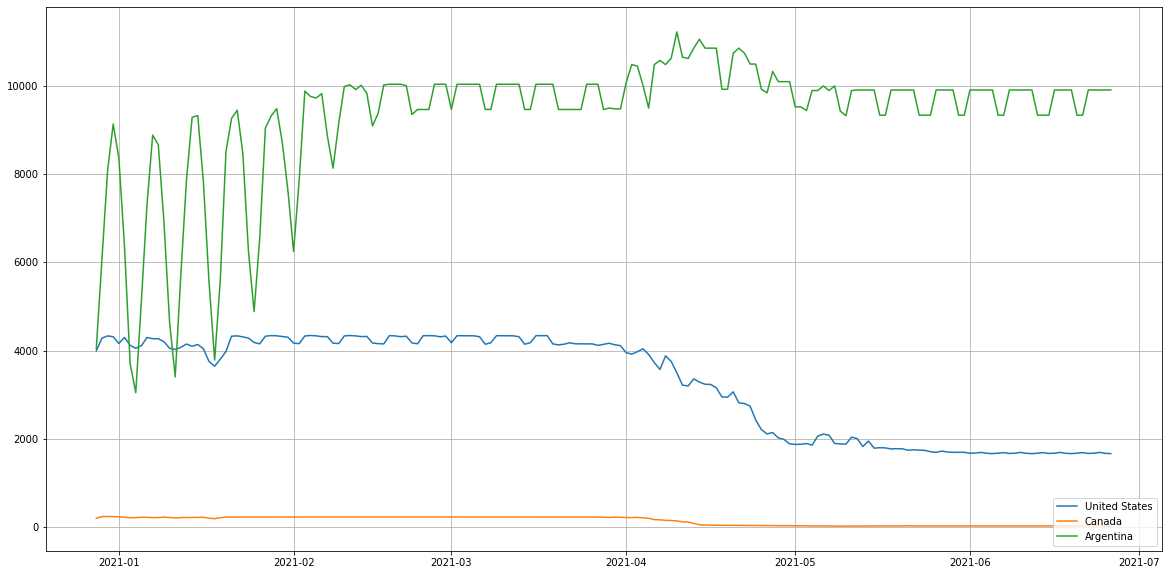

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
pf = pd.read_csv('predictions/val_6_month_future_zero.csv')
pf = pf[['CountryName','Date','PredictedDailyNewCases']]
pf = pf.groupby(['CountryName','Date']).mean()
pf = pf.reset_index()

tf = pf[pf['CountryName']=='United States']
xdates = list(tf['Date'])
xdates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in xdates]
usa = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Canada']
can = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Argentina']
arg = list(tf['PredictedDailyNewCases'])

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.plot(xdates, usa,label='United States')
plt.plot(xdates, can,label='Canada')
plt.plot(xdates, arg,label='Argentina')
plt.legend(loc=4)
plt.grid()
plt.show()